1) DATA PREPARATION

In [19]:
!pip install lightgbm


In [20]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_excel('C:/Users/SARAYU/OneDrive/Desktop/Fraud_Analysis/data/Fraud_Analysis_Dataset.xlsx')

# Display first few rows and basic info
print("First five rows:")
print(df.head())

print("\nInfo:")
print(df.info())

print("\nMissing values per column:")
print(df.isnull().sum()) # check for missing values

print("\nClass balance (isFraud):")
print(df['isFraud'].value_counts())

print("\nBasic statistics of numeric columns:")
print(df.describe())

print("\nType column value counts (categorical distribution):")
if 'type' in df.columns:
    print(df['type'].value_counts())

print("\nDuplicates check (number of duplicate rows):")
print(df.duplicated().sum())


First five rows:
   step      type   amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1  TRANSFER    181.0  C1305486145          181.0             0.0   
1     1  CASH_OUT    181.0   C840083671          181.0             0.0   
2     1  TRANSFER   2806.0  C1420196421         2806.0             0.0   
3     1  CASH_OUT   2806.0  C2101527076         2806.0             0.0   
4     1  TRANSFER  20128.0   C137533655        20128.0             0.0   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  
0   C553264065             0.0             0.0        1  
1    C38997010         21182.0             0.0        1  
2   C972765878             0.0             0.0        1  
3  C1007251739         26202.0             0.0        1  
4  C1848415041             0.0             0.0        1  

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11142 entries, 0 to 11141
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------

2) EXPLORATORY DATA ANALYSIS(EDA)

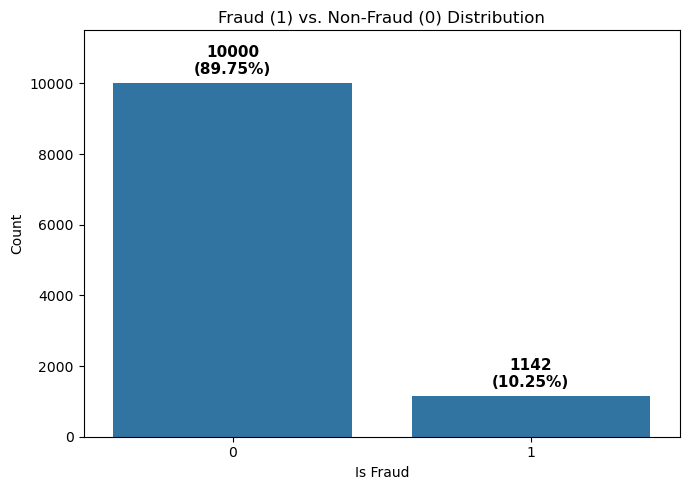

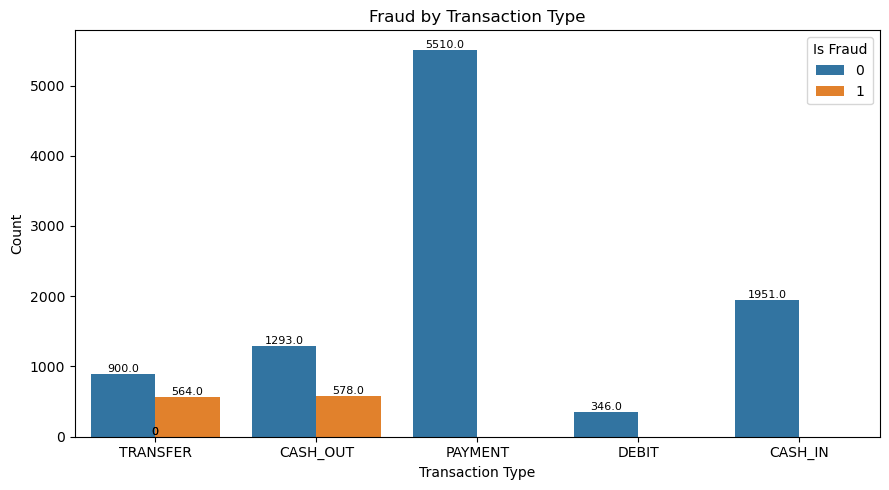

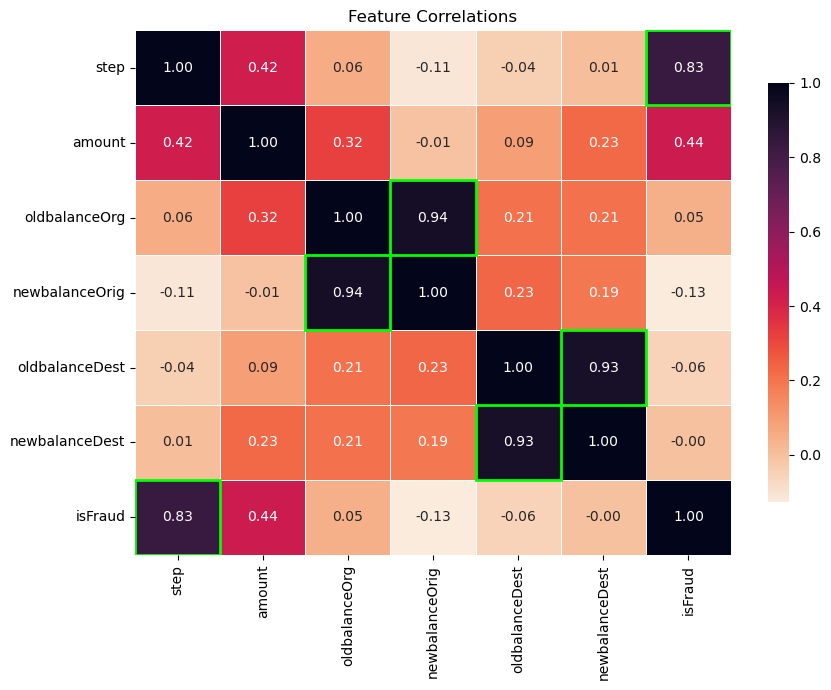

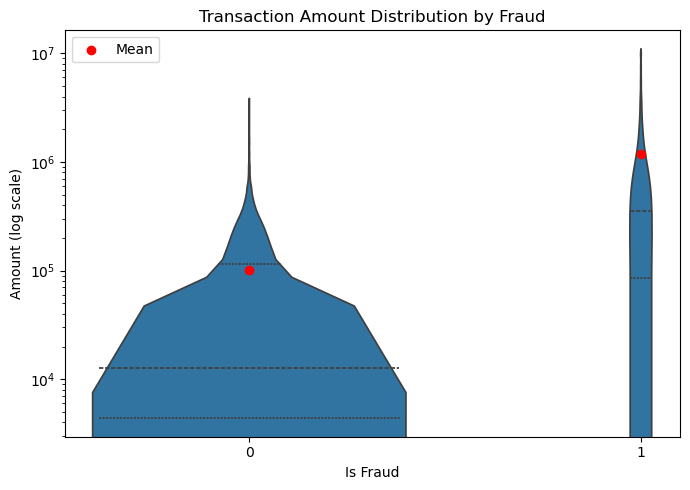

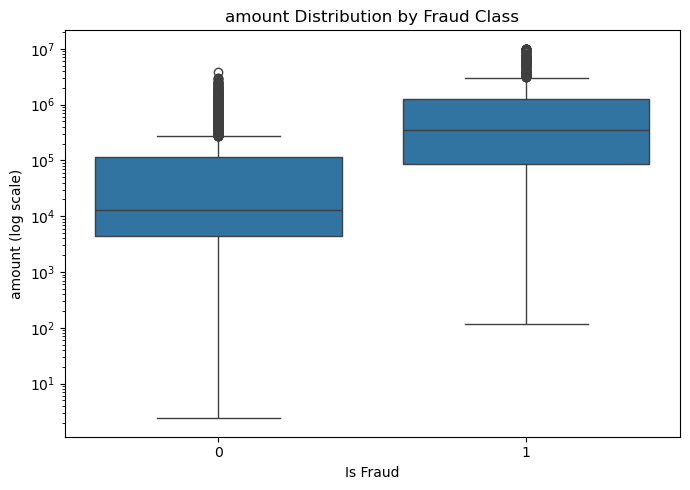

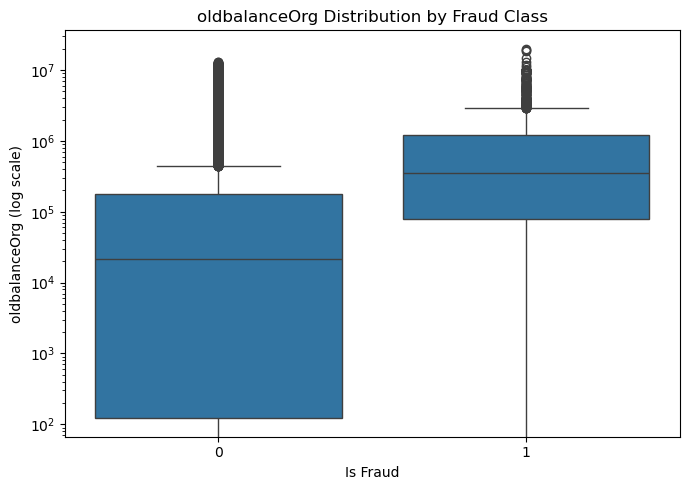

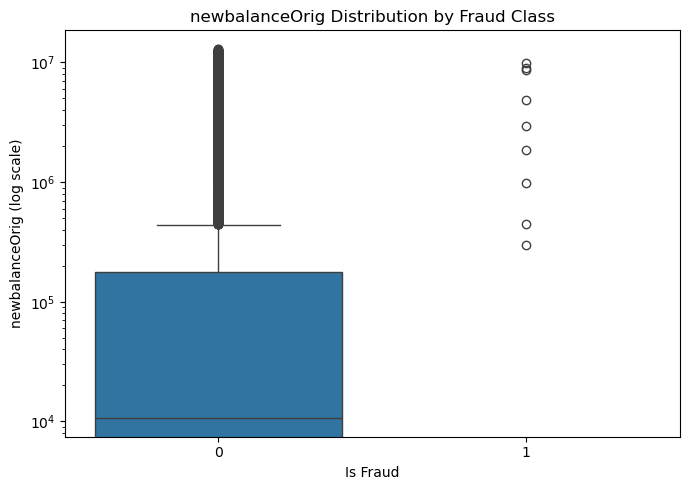

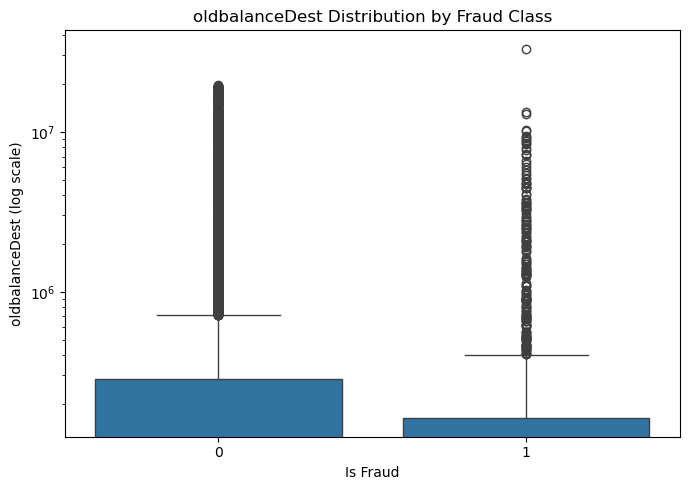

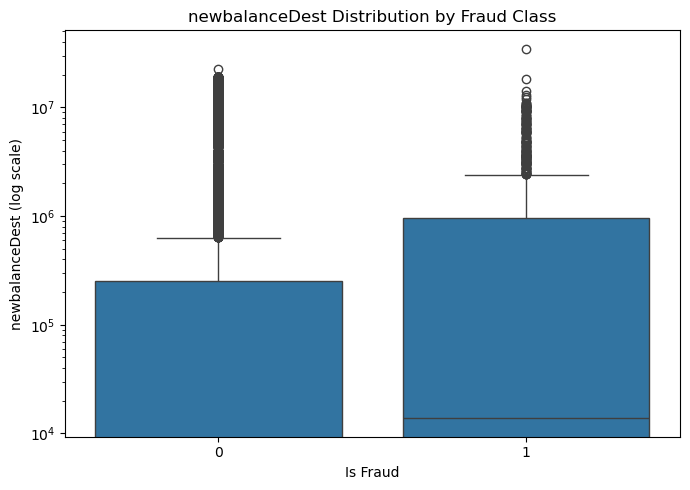

<Figure size 1000x500 with 0 Axes>

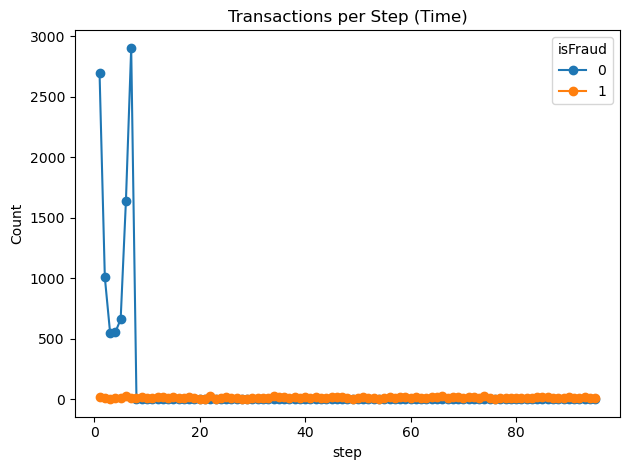

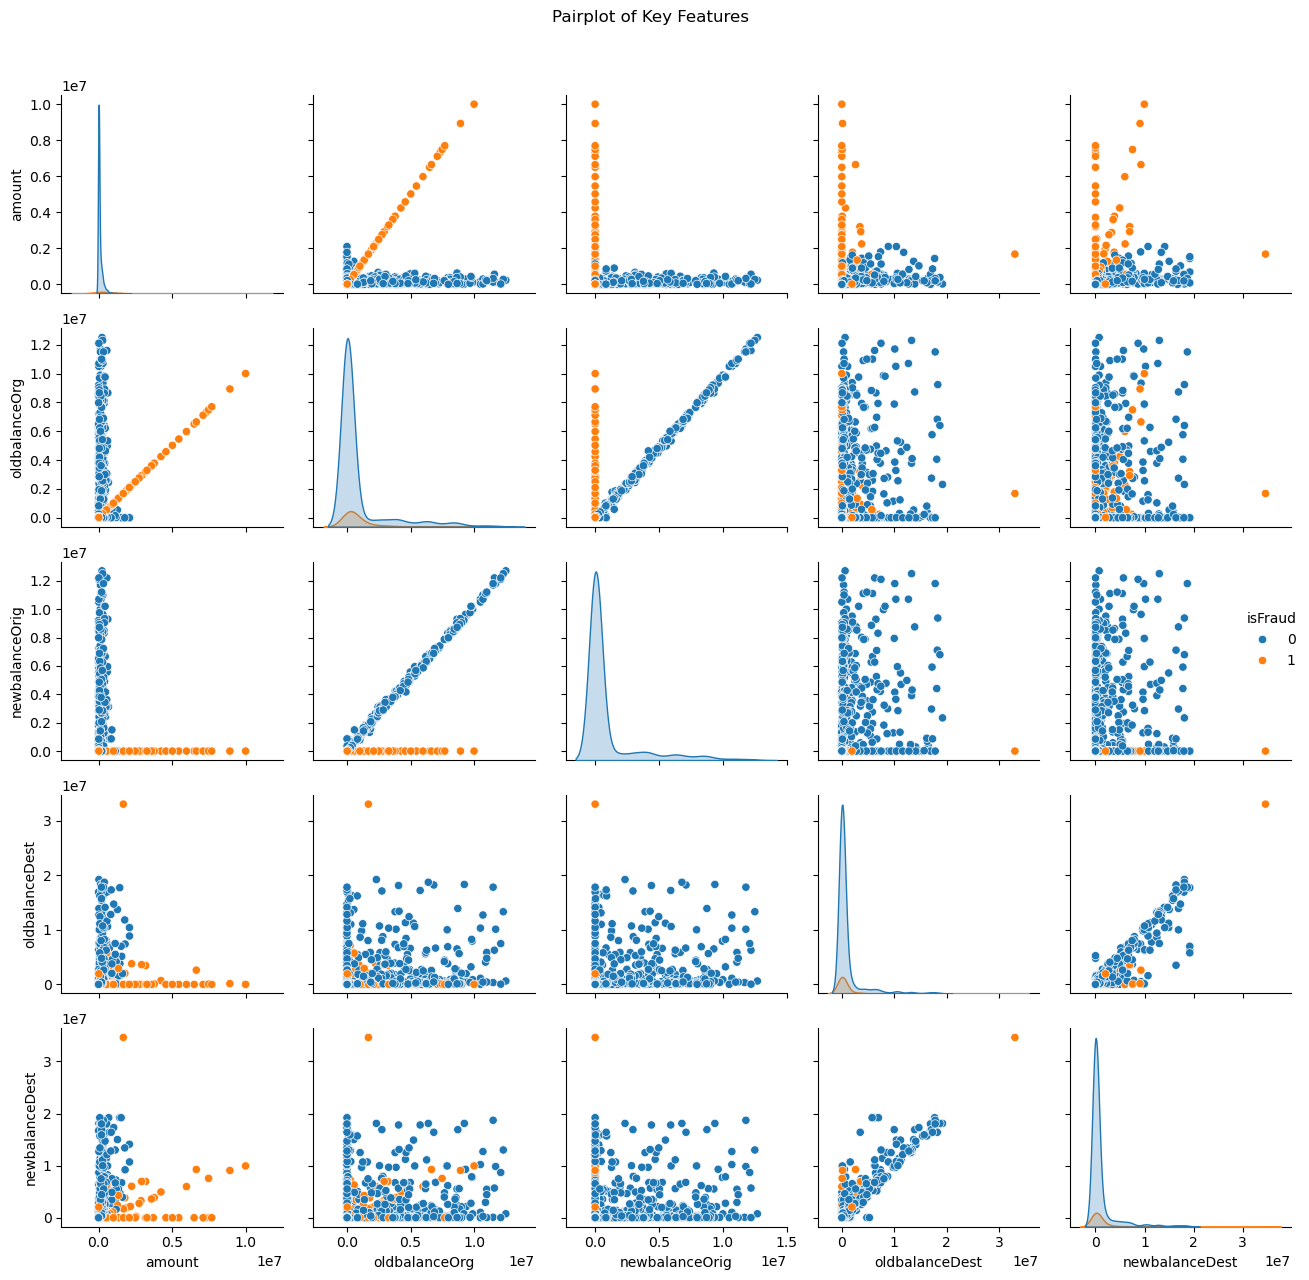

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Class distribution (with count and percent)
plt.figure(figsize=(7,5))
ax = sns.countplot(x='isFraud', data=df)
plt.title('Fraud (1) vs. Non-Fraud (0) Distribution')
total = len(df)
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f'{height:.0f}\n({height/total:.2%})',
        (p.get_x() + p.get_width()/2., height + total*0.015),
        ha='center', va='bottom', fontsize=11, color='black', fontweight='bold'
    )
plt.xlabel("Is Fraud")
plt.ylabel("Count")
plt.ylim(0, max([p.get_height() for p in ax.patches])*1.15)
plt.tight_layout()
plt.show()

# 2. Transaction types by fraud/not-fraud
if 'type' in df.columns:
    plt.figure(figsize=(9,5))
    ax = sns.countplot(x='type', hue='isFraud', data=df)
    plt.title('Fraud by Transaction Type')
    plt.xlabel("Transaction Type")
    plt.ylabel("Count")
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(height, (p.get_x()+p.get_width()/2., height),
                    ha='center', va='bottom', fontsize=8)
    plt.legend(title='Is Fraud')
    plt.tight_layout()
    plt.show()

# 3. Feature correlation heatmap
corr = df.select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(9,7))
sns.heatmap(corr, annot=True, cmap='rocket_r', fmt='.2f', linewidths=0.5, cbar_kws={"shrink": .8})
plt.title("Feature Correlations")
for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        if abs(corr.iloc[i, j]) > 0.7 and i != j:
            plt.gca().add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='lime', lw=2))
plt.tight_layout()
plt.show()

# 4. Amount distribution by fraud class (violinplot + mean)
plt.figure(figsize=(7,5))
sns.violinplot(x='isFraud', y='amount', data=df, inner='quartile')
plt.title('Transaction Amount Distribution by Fraud')
plt.yscale('log')
means = df.groupby('isFraud')['amount'].mean()
for i, m in enumerate(means):
    plt.scatter(i, m, color='red', zorder=3, label='Mean' if i == 0 else "")
plt.legend()
plt.xlabel("Is Fraud")
plt.ylabel("Amount (log scale)")
plt.tight_layout()
plt.show()

# 5. Boxplots of key numeric vars by fraud/not-fraud
for col in ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']:
    plt.figure(figsize=(7,5))
    sns.boxplot(x='isFraud', y=col, data=df)
    plt.title(f'{col} Distribution by Fraud Class')
    plt.yscale('log')
    plt.xlabel("Is Fraud")
    plt.ylabel(f'{col} (log scale)')
    plt.tight_layout()
    plt.show()

# 6. Transactions per step (time plot)
if 'step' in df.columns:
    plt.figure(figsize=(10,5))
    step_counts = df.groupby(['step', 'isFraud']).size().unstack(fill_value=0)
    step_counts.plot(kind='line', marker='o', title='Transactions per Step (Time)')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

# 7. Pairplot for high-impact features (downsample if large)
sample_df = df.sample(min(2000, len(df)), random_state=42)
plot_cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud']
sns.pairplot(sample_df[plot_cols], hue='isFraud', diag_kind='kde')
plt.suptitle('Pairplot of Key Features', y=1.02)
plt.tight_layout()
plt.show()

3)Feature Engineering

In [22]:
# Remove leak-prone ID columns for modeling 
df_model = df.drop(['nameOrig', 'nameDest'], axis=1)

# Create balance diff and ratio features
df_model['orig_bal_diff'] = df_model['oldbalanceOrg'] - df_model['newbalanceOrig']
df_model['dest_bal_diff'] = df_model['oldbalanceDest'] - df_model['newbalanceDest']
df_model['orig_ratio'] = df_model['amount'] / (df_model['oldbalanceOrg'] + 1)
df_model['dest_ratio'] = df_model['amount'] / (df_model['oldbalanceDest'] + 1)

# Remove impossible rows (ensure balances >= 0)
df_model = df_model[(df_model['oldbalanceOrg'] >= 0) & (df_model['oldbalanceDest'] >= 0)]

# One-hot encode 'type' feature if needed
if 'type' in df_model.columns:
    df_model = pd.get_dummies(df_model, columns=['type'], drop_first=False)

# List of columns for scaling: ONLY continuous features!
cols_to_scale = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest',
                 'orig_bal_diff', 'dest_bal_diff', 'orig_ratio', 'dest_ratio']

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_model[cols_to_scale] = scaler.fit_transform(df_model[cols_to_scale])

# Diagnostic checks BEFORE modeling/splitting
print(df_model.describe())
print(df_model.info())
print(df_model['isFraud'].value_counts())
print(df_model[cols_to_scale].std())
print(df_model[cols_to_scale].min())
print(df_model[cols_to_scale].max())


               step        amount  oldbalanceOrg  newbalanceOrig  \
count  11142.000000  1.114200e+04   1.114200e+04    1.114200e+04   
mean       8.717645 -6.122070e-17   3.571207e-17    1.275431e-18   
std       16.067479  1.000045e+00   1.000045e+00    1.000045e+00   
min        1.000000 -2.805006e-01  -4.312445e-01   -3.947543e-01   
25%        2.000000 -2.739953e-01  -4.310452e-01   -3.947543e-01   
50%        6.000000 -2.584503e-01  -4.180990e-01   -3.926390e-01   
75%        7.000000 -7.743752e-02  -2.893413e-01   -3.414417e-01   
max       95.000000  1.287686e+01   8.855201e+00    5.825936e+00   

       oldbalanceDest  newbalanceDest       isFraud  orig_bal_diff  \
count    1.114200e+04    1.114200e+04  11142.000000   11142.000000   
mean     1.402974e-17   -6.249613e-17      0.102495       0.000000   
std      1.000045e+00    1.000045e+00      0.303312       1.000045   
min     -3.415093e-01   -3.699180e-01      0.000000      -1.499869   
25%     -3.415093e-01   -3.699180e-01

In [23]:
# ----- Export for Power BI -----
df_model.to_csv('C:/Users/SARAYU/OneDrive/Desktop/Fraud_Analysis/data/processed_fraud_data.csv', index=False)
print("Exported processed data for Power BI dashboard.")



Exported processed data for Power BI dashboard.


In [24]:
# ----- Diagnostics after scaling/feature prep -----
print(df_model.describe())
print(df_model.info())
print(df_model['isFraud'].value_counts())
print(df_model[cols_to_scale].std())
print(df_model[cols_to_scale].min())
print(df_model[cols_to_scale].max())


               step        amount  oldbalanceOrg  newbalanceOrig  \
count  11142.000000  1.114200e+04   1.114200e+04    1.114200e+04   
mean       8.717645 -6.122070e-17   3.571207e-17    1.275431e-18   
std       16.067479  1.000045e+00   1.000045e+00    1.000045e+00   
min        1.000000 -2.805006e-01  -4.312445e-01   -3.947543e-01   
25%        2.000000 -2.739953e-01  -4.310452e-01   -3.947543e-01   
50%        6.000000 -2.584503e-01  -4.180990e-01   -3.926390e-01   
75%        7.000000 -7.743752e-02  -2.893413e-01   -3.414417e-01   
max       95.000000  1.287686e+01   8.855201e+00    5.825936e+00   

       oldbalanceDest  newbalanceDest       isFraud  orig_bal_diff  \
count    1.114200e+04    1.114200e+04  11142.000000   11142.000000   
mean     1.402974e-17   -6.249613e-17      0.102495       0.000000   
std      1.000045e+00    1.000045e+00      0.303312       1.000045   
min     -3.415093e-01   -3.699180e-01      0.000000      -1.499869   
25%     -3.415093e-01   -3.699180e-01

In [25]:
#Train-Test Split & SMOTE for Class Balance
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Prepare features/target
X = df_model.drop('isFraud', axis=1)
y = df_model['isFraud']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# SMOTE class balancing (do not use for booleans, or use SMOTENC with categorical features)
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("Post-SMOTE train set shape:", X_train_res.shape)
print("Resampled class balance:", y_train_res.value_counts())


Post-SMOTE train set shape: (15998, 15)
Resampled class balance: isFraud
0    7999
1    7999
Name: count, dtype: int64


In [26]:
#Model Training
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import lightgbm as lgb

# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_res, y_train_res)
y_pred_lr = lr.predict(X_test)
y_pred_proba_lr = lr.predict_proba(X_test)[:, 1]

# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_res, y_train_res)
y_pred_rf = rf.predict(X_test)
y_pred_proba_rf = rf.predict_proba(X_test)[:, 1]

# Gradient Boosting
gb = GradientBoostingClassifier(n_estimators=200, random_state=42)
gb.fit(X_train_res, y_train_res)
y_pred_gb = gb.predict(X_test)
y_pred_proba_gb = gb.predict_proba(X_test)[:, 1]

# LightGBM
lgbm = lgb.LGBMClassifier(n_estimators=200, random_state=42)
lgbm.fit(X_train_res, y_train_res)
y_pred_lgbm = lgbm.predict(X_test)
y_pred_proba_lgbm = lgbm.predict_proba(X_test)[:, 1]


[LightGBM] [Info] Number of positive: 7999, number of negative: 7999
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000400 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2401
[LightGBM] [Info] Number of data points in the train set: 15998, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit


--- Logistic Regression ---
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99      2001
           1       0.87      0.96      0.91       228

    accuracy                           0.98      2229
   macro avg       0.93      0.97      0.95      2229
weighted avg       0.98      0.98      0.98      2229

Confusion Matrix:
 [[1968   33]
 [   8  220]]
ROC AUC Score:  0.9907502389156299
Precision:  0.8695652173913043
Recall:  0.9649122807017544
F1 Score:  0.9147609147609148

--- Random Forest ---
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2001
           1       1.00      0.99      1.00       228

    accuracy                           1.00      2229
   macro avg       1.00      1.00      1.00      2229
weighted avg       1.00      1.00      1.00      2229

Confusion Matrix:
 [[2001    0]
 [   2  226]]
ROC AUC Score:  0.999984656794

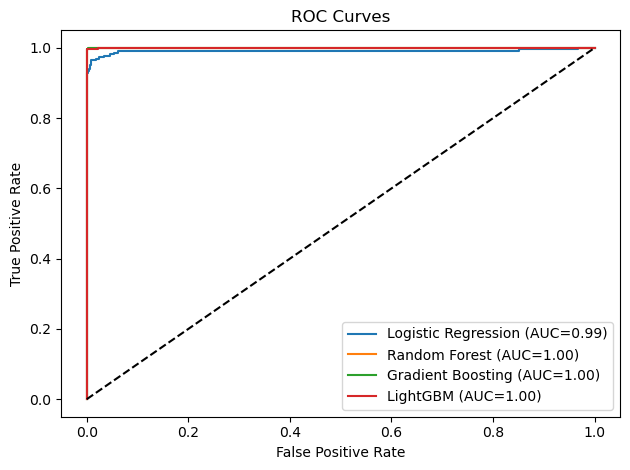

In [27]:
#Model Evaluation
from sklearn.metrics import (classification_report, roc_auc_score, confusion_matrix,
                            precision_score, recall_score, f1_score, roc_curve)

models = {
    'Logistic Regression': (y_pred_lr, y_pred_proba_lr),
    'Random Forest': (y_pred_rf, y_pred_proba_rf),
    'Gradient Boosting': (y_pred_gb, y_pred_proba_gb),
    'LightGBM': (y_pred_lgbm, y_pred_proba_lgbm)
}

for model_name, (y_pred, y_pred_proba) in models.items():
    print(f"\n--- {model_name} ---")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("ROC AUC Score: ", roc_auc_score(y_test, y_pred_proba))
    print("Precision: ", precision_score(y_test, y_pred))
    print("Recall: ", recall_score(y_test, y_pred))
    print("F1 Score: ", f1_score(y_test, y_pred))
    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC={roc_auc_score(y_test, y_pred_proba):.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.tight_layout()
plt.show()


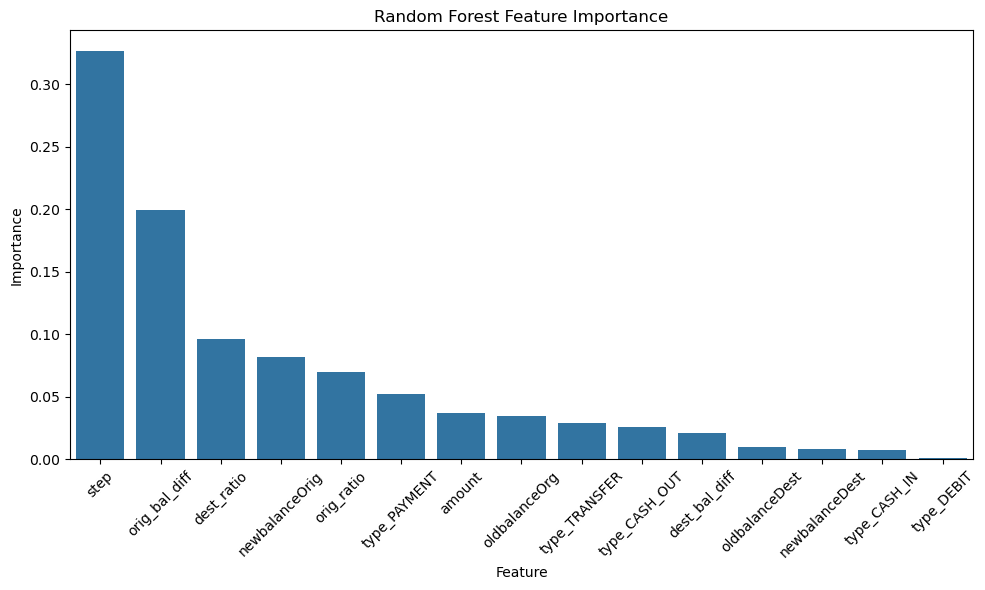

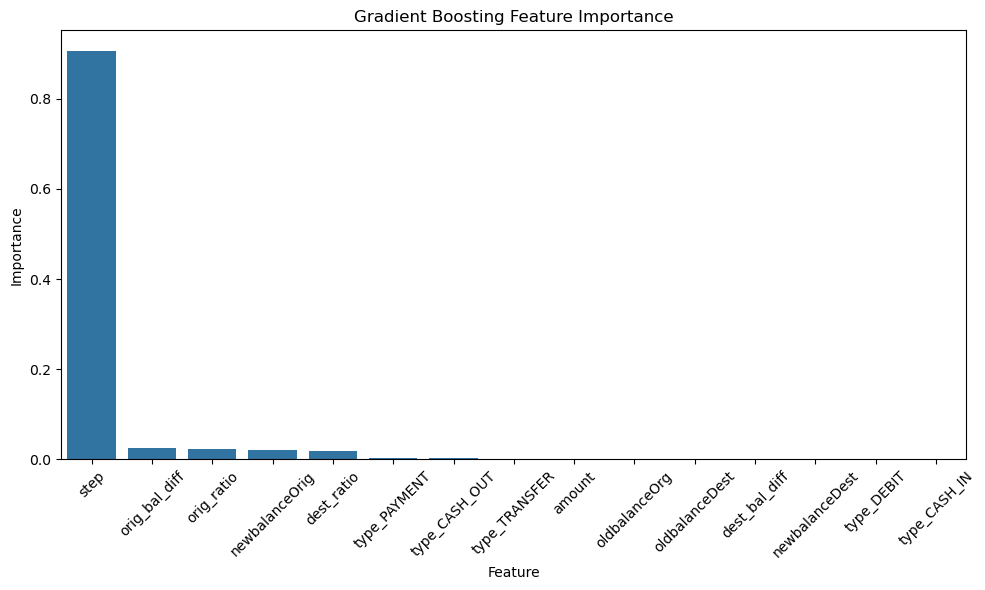

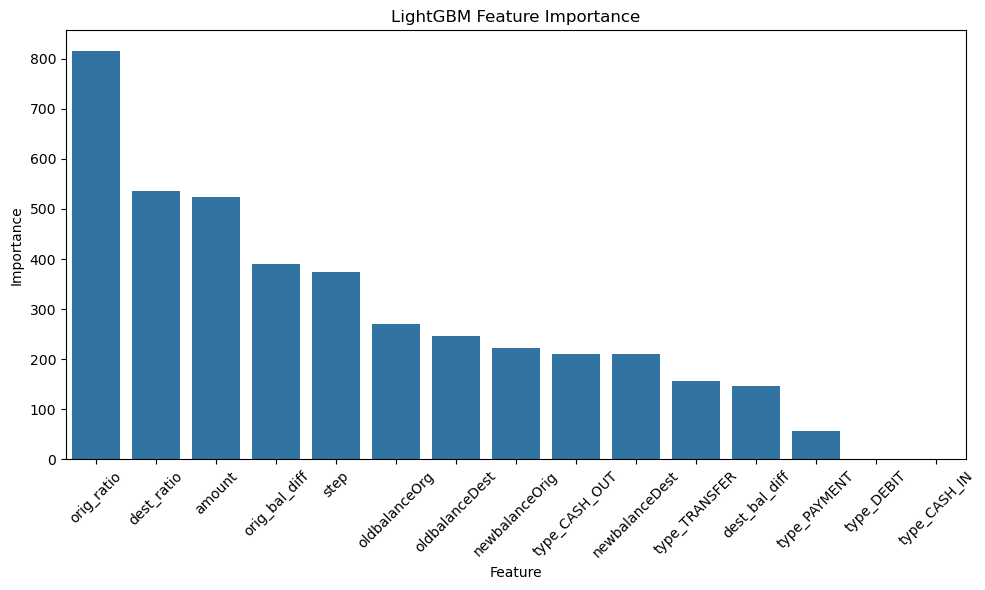

In [28]:
#Feature Importance for Tree Models
def plot_feature_importance(model, X, title):
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        plt.figure(figsize=(10,6))
        sns.barplot(x=X.columns[indices], y=importances[indices])
        plt.title(title)
        plt.xlabel('Feature')
        plt.ylabel('Importance')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

plot_feature_importance(rf, X_train_res, 'Random Forest Feature Importance')
plot_feature_importance(gb, X_train_res, 'Gradient Boosting Feature Importance')
plot_feature_importance(lgbm, X_train_res, 'LightGBM Feature Importance')


In [29]:
#Financial Impact Analysis
# Add this after model evaluation, using your BEST/MOST BUSINESS-IMPORTANT model (e.g., LightGBM)
test_results = X_test.copy()
test_results['true_label'] = y_test.values
test_results['pred_label'] = y_pred_lgbm  # change to your preferred model
test_results['amount'] = df.loc[X_test.index, 'amount']

# Calculate financial impact
false_negatives = test_results[(test_results['true_label']==1) & (test_results['pred_label']==0)]
false_positives = test_results[(test_results['true_label']==0) & (test_results['pred_label']==1)]
true_positives  = test_results[(test_results['true_label']==1) & (test_results['pred_label']==1)]

total_lost_due_to_fraud = false_negatives['amount'].sum()
total_investigation_cost = false_positives['amount'].sum()  # Or multiply by cost-per-investigation
total_saved_amount = true_positives['amount'].sum()

print("Estimated financial loss due to missed fraud:", total_lost_due_to_fraud)
print("Estimated operational cost from false alarms:", total_investigation_cost)
print("Potential fraud value detected and saved:", total_saved_amount)


Estimated financial loss due to missed fraud: 416001.33
Estimated operational cost from false alarms: 98247.27
Potential fraud value detected and saved: 235430525.04


In [30]:
# Add ratio features
df['orig_ratio'] = df['newbalanceOrig'] / (df['oldbalanceOrg'] + 1e-8) # add small number to prevent division by zero
df['dest_ratio'] = df['newbalanceDest'] / (df['oldbalanceDest'] + 1e-8)

# Add diff features (if not already done)
df['orig_bal_diff'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['dest_bal_diff'] = df['oldbalanceDest'] - df['newbalanceDest']

# List every column you want to export
columns_to_export = [
    'step',
    'type',
    'amount',
    'nameOrig',
    'oldbalanceOrg',
    'newbalanceOrig',
    'nameDest',
    'oldbalanceDest',
    'newbalanceDest',
    'isFraud',
    'orig_bal_diff',
    'dest_bal_diff',
    'orig_ratio',
    'dest_ratio'
]

# Export with all needed columns
df[columns_to_export].to_csv('C:/Users/SARAYU/OneDrive/Desktop/Fraud_Analysis/data/processed_fraud_data.csv', index=False)

print("Exported processed data for Power BI with all required features included.")


Exported processed data for Power BI with all required features included.


In [31]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
import pandas as pd

models = {
    'Logistic Regression': (y_pred_lr, y_pred_proba_lr),
    'Random Forest': (y_pred_rf, y_pred_proba_rf),
    'Gradient Boosting': (y_pred_gb, y_pred_proba_gb),
    'LightGBM': (y_pred_lgbm, y_pred_proba_lgbm)
}

results = []

for model_name, (y_pred, y_pred_proba) in models.items():
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, y_pred)
    
    results.append([
        model_name,
        round(precision, 4),
        round(recall, 4),
        round(f1, 4),
        round(roc_auc, 4),
        round(accuracy, 4)
    ])

columns = ['Model', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'Accuracy']
results_df = pd.DataFrame(results, columns=columns)
print(results_df)


                 Model  Precision  Recall  F1-Score  ROC-AUC  Accuracy
0  Logistic Regression     0.8696  0.9649    0.9148   0.9908    0.9816
1        Random Forest     1.0000  0.9912    0.9956   1.0000    0.9991
2    Gradient Boosting     0.9956  0.9956    0.9956   1.0000    0.9991
3             LightGBM     0.9956  0.9956    0.9956   0.9999    0.9991


In [33]:
amounts_test = df.loc[X_test.index, 'amount'].values

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import pandas as pd

# Get confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Financial impact
test_df = pd.DataFrame({
    'true': y_test, 
    'pred': y_pred, 
    'amount': amounts_test  # your transaction amounts
})

prevented = test_df[(test_df['true']==1) & (test_df['pred']==1)]['amount'].sum()
missed = test_df[(test_df['true']==1) & (test_df['pred']==0)]['amount'].sum()
investigation_cost = fp * 750
net_benefit = prevented - missed - investigation_cost
annual_benefit = net_benefit * (365 / 4.17)

# Print results
print(f"TP: {tp:,} | TN: {tn:,} | FP: {fp:,} | FN: {fn:,}")
print(f"Fraud Prevented: ₹{prevented:,.0f}")
print(f"Fraud Missed: ₹{missed:,.0f}")
print(f"Net Benefit: ₹{net_benefit:,.0f}")
print(f"Annual: ₹{annual_benefit:,.0f}")


TP: 227 | TN: 2,000 | FP: 1 | FN: 1
Fraud Prevented: ₹235,430,525
Fraud Missed: ₹416,001
Net Benefit: ₹235,013,774
Annual: ₹20,570,749,977
